In [4]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd
from scipy.integrate import solve_ivp

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [5]:
def update_state(c,b,g_0,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix = 1j * g_0 * np.sqrt(omega_A / L) * np.exp(-1j * (omega_tab - omega_A) * t)

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

<h1> RG Scheme </h1>

In [6]:
def RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)
    c_array = np.zeros((nb_pts_time, n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, g_0, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, g_0, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [7]:
def get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    #k_tab = np.abs(omega_tab_p)
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    


    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    print("Preparing the initial state...")
    c_init = np.zeros(n_modes, dtype=complex)
    b_init = 0

    c_init = np.exp(-(0.5*(k_tab - omega_0)**2) * sigma**2) * np.exp(-1j * k_tab * x_0)
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=progress_bar)

    ##Compute overlap with the initial state
    print("Computing overlap with the initial state...")
    overlap_tab = np.zeros(int(T / dt), dtype=complex)
    for i in range(int(T / dt)):
        c_current = c_array[i]
        b_current = b_array[i]
        overlap_tab[i] = np.abs (np.conjugate(c_current) @ c_init + b_current * np.conjugate(b_init))**2


    return c_array, b_array, overlap_tab, k_tab

<h1> First test </h1>

In [8]:
L = 5*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 6.7
omega_max = 10

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

#check some parameters
gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("sigma in momentum space: ", sigma_momentum)
print("Value of gamma: ", gamma, " and life time of the excited state: ", 1/gamma)

50% Reflectivity for omega_0_m =  0  and omega_0_p =  6
sigma in momentum space:  1.0185916357881302
Value of gamma:  3  and life time of the excited state:  0.3333333333333333


In [9]:
c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=True)

Number of modes:  51
Preparing the initial state...
Evolving the state...


  0%|          | 0/784 [00:00<?, ?it/s]

Computing overlap with the initial state...


<h1> Occupation numbers </h1>

In [10]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
n_modes = len(k_tab)

nb_pts_time = int(T / dt)
P_plus = np.zeros(nb_pts_time)
P_minus = np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    P_plus[i] = np.sum(np.abs(c_array[i,n_modes//2:])**2)
    P_minus[i] = np.sum(np.abs(c_array[i,:n_modes//2])**2)

print("Quantity conservation: ", P_plus[-1] + P_minus[-1])
print("Final overlap with initial state: ", overlap_tab[-1])

  0%|          | 0/785 [00:00<?, ?it/s]

Quantity conservation:  0.9999999610326167
Final overlap with initial state:  (0.5013743146450391+0j)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


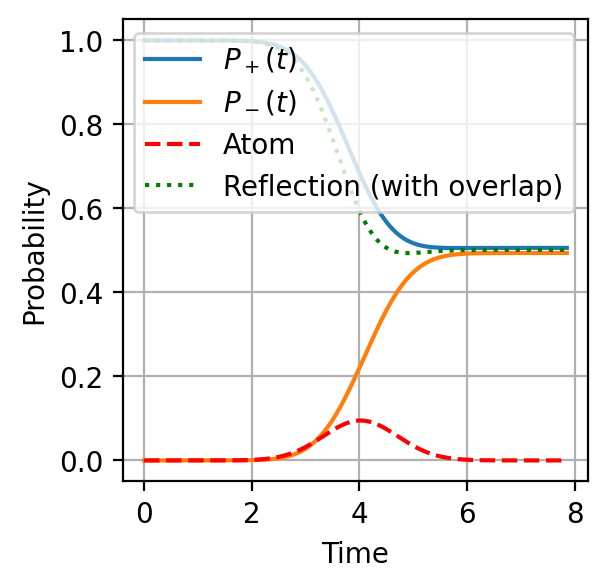

In [11]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, P_plus, label=r'$P_+(t)$')
ax.plot(time_array, P_minus, label=r'$P_-(t)$')
#ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(time_array, np.abs(b_array)**2, label='Atom', linestyle='--', color='red')   
ax.plot(time_array, overlap_tab, label='Reflection (with overlap)', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
#ax.set_ylim(0, 1.1)
ax.legend()
ax.grid()

plt.show()

<h1> Check occupation numbers </h1>

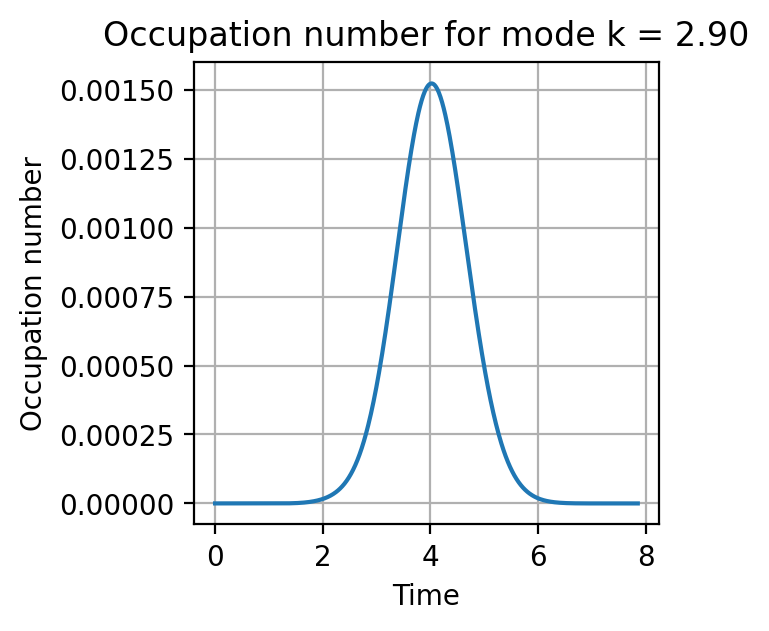

In [12]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
n_modes = len(k_tab)

k_to_show = 2.9
index_to_show = np.argmin(np.abs(k_tab - k_to_show))
c_to_show = c_array[:, index_to_show]

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, np.abs(c_to_show)**2)
ax.set_xlabel('Time')
ax.set_ylabel('Occupation number')
ax.set_title(f'Occupation number for mode k = {k_to_show:.2f}')
ax.grid()
plt.show()

<h1> Reflection against detunning </h1>

In [13]:
L = 5*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_max = 10

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4

gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("sigma in momentum space: ", sigma_momentum)
print("Value of gamma: ", gamma, " and life time of the excited state: ", 1/gamma)


50% Reflectivity for omega_0_m =  0  and omega_0_p =  6
sigma in momentum space:  1.0185916357881302
Value of gamma:  3  and life time of the excited state:  0.3333333333333333


Run the calculations

In [14]:
#get the number of modes
nb_freq = 19
omega_0_tab = np.linspace(omega_A - 3*gamma, omega_A + 3*gamma, nb_freq)
#throw away negative frequencies
omega_0_tab = omega_0_tab[omega_0_tab > 0]
nb_freq = len(omega_0_tab)

reflection_tab = np.zeros(nb_freq)
overlap_final_tab = np.zeros(nb_freq)

for i, omega_0 in enumerate(tqdm(omega_0_tab)):
    print(f"Running for omega_0 = {omega_0}")
    c_array, b_array, overlap_tab, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=False, progress_bar=False)
    n_modes = len(k_tab)
    reflection_tab[i] = np.sum(np.abs(c_array[-1,:n_modes//2])**2)
    overlap_final_tab[i] = overlap_tab[-1]

  0%|          | 0/12 [00:00<?, ?it/s]

Running for omega_0 = 1.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 2.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 3.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 4.0
Preparing the initial state...
Evolving the state...


/var/folders/ds/7w970h197d59hh_2dj4ry5qw0000gn/T/ipykernel_2197/4219607339.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_final_tab[i] = overlap_tab[-1]


Computing overlap with the initial state...
Running for omega_0 = 5.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 6.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 7.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 8.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 9.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 10.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 11.0
Preparing the initial state...
Evolving the state...
Computing overlap with the initial state...
Running for omega_0 = 12.0
Preparing the initial state...
Evolving the state...
Computing ove

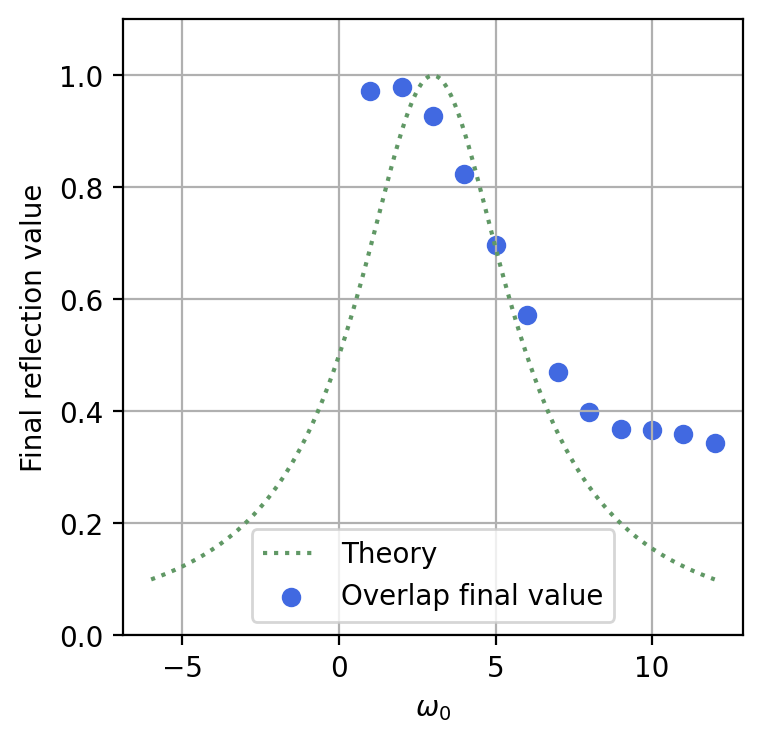

In [16]:
#theoretical curve
omega_0_tab_theory = np.linspace(omega_A - 3*gamma, omega_A + 3*gamma, 1000)
theory_curve = 1 / (1 + (omega_0_tab_theory - omega_A)**2 / (g_0**2 * omega_A)**2)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.plot(omega_0_tab_theory, theory_curve, linestyle=':', color="#609865", label='Theory')
#ax.scatter(omega_0_tab - omega_A, reflection_tab, marker='o', color="blue", label='Numerical')
ax.scatter(omega_0_tab, 1- overlap_final_tab, marker='o', color="royalblue", label='Overlap final value')
ax.legend()
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel('Final reflection value')
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

<h1> Check UV cutoff near resonance </h1>

In [ ]:
L = 250*pi
T = L/2
dt = 0.05

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = 2.99

print("omega_0 = ", omega_0)
print("Gamma = ", gamma)

#numerical implementation of momentum space
#omega_max_tab = np.linspace(5, 200, 20)

nb_freq = 30
omega_max_tab = np.linspace(2*omega_A, 50, nb_freq)

final_overlap_tab = np.zeros(len(omega_max_tab))
final_reflection_tab = np.zeros(len(omega_max_tab))
final_transmission_tab = np.zeros(len(omega_max_tab))

for i, omega_max in enumerate(tqdm(omega_max_tab)):
    print(f"Running for omega_max = {omega_max}")

    c_array, b_array, overlap_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes=False)
    
    final_overlap_tab[i] = overlap_tab[-1]
    
    # Prepare the k_tab for occupation numbers
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    n_modes = len(k_tab)
    final_reflection_tab[i] = np.sum(np.abs(c_array[-1,:n_modes//2])**2)
    final_transmission_tab[i] = np.sum(np.abs(c_array[-1,n_modes//2:])**2)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab, final_transmission_tab, marker='o',markerfacecolor='white', markersize=3)
ax.plot(omega_max_tab, final_reflection_tab, marker='o',markerfacecolor='white', markersize=3)
ax.plot(omega_max_tab, final_overlap_tab, marker='o', color='green',markerfacecolor='white', markersize=3)
ax.set_xlabel(r'$\omega_{max}$')
ax.set_ylabel('Final overlap value')
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

<h1> Some theoretical check </h1>

In [ ]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
n_modes = len(k_tab)

def phi(t,b):
    return -1j*g_0 * pi**(-1/4) * np.sqrt(omega_A/sigma)  * np.exp (-(x_0 + t)**2 / (2*sigma**2)) * np.exp(1j*(omega_A-omega_0)*t) * np.exp(1j*omega_0*x_0) - g_0**2 * omega_A * b

#solve db/dt = phi(b,t)

# Time array
t_span = (0, T)
t_eval = np.linspace(0, T, int(T / dt))

# Initial condition
b_init = [0.0 + 0.0j]  # make it complex

# Solve
solution = solve_ivp(phi, t_span, b_init, t_eval=t_eval)

# Extract solution
time_array = solution.t
b_solution = solution.y[0]

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, np.abs(b_solution)**2, label='Atom (theory)', linestyle='--', color='red')
ax.plot(time_array, np.abs(b_array)**2, label='Atom (numerical)', linestyle='-', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation number')
ax.legend()
#ax.set_ylim(0, 1.1)
ax.grid()
plt.show()